In [1]:
import torch
import pickle
from matplotlib import pyplot as plt
import numpy as np
from itertools import chain
from helper.model import *
from helper.utils import *
from helper.distance_map import *
from helper.evaluate import *
from scipy import stats
from tqdm import tqdm
import pandas as pd
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

args_train_data = "train_remove1of3_70"
args_test_data = "test_remove1of3_70"
args_model_name = "overprediction/remove1of3_"  
args_weight_path = "overprediction_ensemble/" 
args_N_models = 8

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32
#
id_ec_train, ec_id_dict_train = get_ec_id_dict('./data/'+args_train_data+'.csv')
id_ec_test, _ = get_ec_id_dict('./data/'+args_test_data+'.csv')

In [ ]:
# keep models output embeddings
esm_embedding_train = esm_embedding(ec_id_dict_train, device, dtype)

for i in (range(args_N_models)):
    model_i = LayerNormNet(512, 128, device, dtype)
    model_name_i = args_model_name + str(i)
    print("loading model:", model_name_i)
    checkpoint = torch.load('./model/' + model_name_i + '.pth')
    model_i.load_state_dict(checkpoint)
    model_i.eval()
    emb_train_i = model_i(esm_embedding_train) 
    emb_test_i = model_embedding_test(id_ec_test, model_i, device, dtype) 
    emb_train_i_path = args_weight_path+args_test_data+"_emb_train_"+str(i)+'.pt'
    emb_test_i_path = args_weight_path+args_test_data+"_emb_test_"+str(i)+'.pt'
    torch.save(emb_train_i, emb_train_i_path)
    torch.save(emb_test_i, emb_test_i_path)

In [ ]:
# get distance map for all models
eval_dist_lst_all = []
for i in (range(args_N_models)):
    emb_train_i_path = args_weight_path+args_test_data+"_emb_train_"+str(i)+'.pt'
    emb_test_i_path = args_weight_path+args_test_data+"_emb_test_"+str(i)+'.pt'
    emb_train = torch.load(emb_train_i_path)
    emb_test = torch.load(emb_test_i_path)
    eval_dist = get_dist_map_test(
            emb_train, emb_test, ec_id_dict_train, id_ec_test, 
            device, dtype, dot=False)
    eval_dist_lst_all.append(eval_dist)

In [15]:
def get_metrics_bins(eval_dist_lst, min_std, max_std, N_random_models=5, N_bins=10):
    # use_std_pred: whether use percentile 
    # calculated from maxsep predictions only
    ############################################################
    eval_dist_w_std = dict()
    eval_dist_mean = dict()
    # keep track of all query/ec dist std for future ranking
    all_dist_std = []
    # calculate distance map with standard deviation
    print("calculating mean distance and std")
    for query in  tqdm(eval_dist_lst[0].keys()):
        dist_mean_std = dict()
        dist_mean_dict = dict()
        # get the ec/distance dictionary
        for ec in eval_dist_lst[0][query]:
            # find distances for this query/ec pair for these models
            all_dist_per_ec = []
            for i in range(N_random_models):
                all_ec_dist_per_query = eval_dist_lst[i][query] 
                dist_i = all_ec_dist_per_query[ec]
                all_dist_per_ec.append(dist_i)
            dist_mean = np.mean(all_dist_per_ec)
            dist_std = np.std(all_dist_per_ec)
            all_dist_std.append(dist_std)
            dist_mean_std[ec] = (dist_mean, dist_std)
            dist_mean_dict[ec] = dist_mean
        eval_dist_w_std[query] = dist_mean_std
        eval_dist_mean[query] = dist_mean_dict    
 
    ############################################################
    # get max sep prediction results for all models
    certainty_from_all_dist_lst = []
    certainty_from_dist_in_pred_lst = []
    all_std_in_pred_lst = []
    dist_map_df = pd.DataFrame.from_dict(eval_dist_mean); 
    first_grad=True; use_max_grad=False
    # get predictions
    query_prediction_lst = []
    for query in tqdm(dist_map_df.columns):
        smallest_10_dist_df = dist_map_df[query].nsmallest(10)
        dist_lst = list(smallest_10_dist_df)
        max_sep_i = maximum_separation(dist_lst, first_grad, use_max_grad)
        predictions = []
        for i in range(max_sep_i+1):
            EC_i = smallest_10_dist_df.index[i]
            # remove last class
            EC_removed_last = '.'.join((EC_i.split('.')[:3]) + ['-'])
            dist_i = smallest_10_dist_df[i]
            predictions.append((EC_removed_last, dist_i))
            _, dist_std = eval_dist_w_std[query][EC_i]
            # keep track of all dist std appeared in prediction
            all_std_in_pred_lst.append(dist_std)
        query_prediction_lst.append((query, predictions))   
    ############################################################
    query_count = 0
    all_dist = []
    interval_std = (max_std - min_std)/N_bins
    bins_query_by_std_threshold = [[] for i in range(N_bins)]

    for query in tqdm(dist_map_df.columns):
        smallest_10_dist_df = dist_map_df[query].nsmallest(10)
        dist_lst = list(smallest_10_dist_df)
        max_sep_i = maximum_separation(dist_lst, first_grad, use_max_grad)
        # bin by std threshold
        std_per_query = []
        for i in range(max_sep_i+1):
            EC_i = smallest_10_dist_df.index[i]
            dist_i = smallest_10_dist_df[i]
            _, dist_std = eval_dist_w_std[query][EC_i]
            std_per_query.append(dist_std)
        
        for bin_i in range(N_bins):
            threshold_std = min_std + (bin_i+1)*interval_std         
            for std in std_per_query:
                if std <= threshold_std + 1e-4:
                    bins_query_by_std_threshold[bin_i].append(query_count)
                    break
        query_count += 1
    ############################################################
    # write the top 10 closest EC to _top10.csv
    out_filename = './eval/' + args_test_data
    # _ = write_top10_choices(eval_df, out_filename)
    # maximum separation results
    write_max_sep_choices_overprediction(
        dist_map_df, out_filename, first_grad=True, use_max_grad=False)
    # get preds and true labels
    pred_label = get_pred_labels(out_filename, pred_type='_maxsep')
    pred_probs = get_pred_probs(out_filename, pred_type='_maxsep')
    true_label, all_label = get_true_labels('./data/'+args_test_data)
    pre, rec, f1, roc, acc = get_eval_metrics_new(
        pred_label, pred_probs, true_label, all_label)
    results_all = (pre, rec, f1, roc, acc)
    #print("results:", results_all)
    # collect results by bin
    results_per_bin = [] 
    for bin_i in range(N_bins):
        query_bin = bins_query_by_std_threshold[bin_i]
        #print("Bin", bin_i, len(query_bin))
        pred_label_i = [pred_label[i] for i in query_bin]
        pred_probs_i = [pred_probs[i] for i in query_bin]
        true_label_i = [true_label[i] for i in query_bin]
        all_label_i = set(list(chain.from_iterable(true_label_i)))
        #print(pred_label_i, pred_probs_i, true_label_i, all_label_i)
        # print(pred_label_i, pred_probs_i, true_label_i)
        # raise
        pre, rec, f1, roc, acc = get_eval_metrics_new(
            pred_label_i, pred_probs_i, true_label_i, all_label_i)
        results_per_bin.append((pre, rec, f1, roc, acc))
    
    return results_per_bin, results_all

In [16]:
args_N_experiment = 15
args_N_random_models = 5
args_N_bins = 20
# randomly choose models to do ensemble
np.random.seed(1)
models_experiments = [np.random.choice(8, 5, replace=False) 
                      for i in range(args_N_experiment)]

In [17]:
MIN_STD = 0.3
MAX_STD = 2.5 # found emperically

result_bin_per_experiment = []
result_all_per_experiment = []
for experiment in models_experiments:
    eval_dist_lst = [eval_dist_lst_all[model] for model in experiment] 
    results_per_bin, results_all = get_metrics_bins(
        eval_dist_lst, MIN_STD, MAX_STD,
        N_random_models=args_N_random_models, N_bins=args_N_bins)
    result_bin_per_experiment.append(results_per_bin)
    result_all_per_experiment.append(results_all)

calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3128.19it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3200.02it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3342.52it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3365.58it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3377.08it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3365.52it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3400.72it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3308.47it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3264.15it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3031.08it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3189.59it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3448.72it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3059.60it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3424.61it/s]


calculating mean distance and std


100%|██████████| 488/488 [00:00<00:00, 3128.25it/s]


In [18]:
with open('overprediction_ensemble/remove1of3.pkl', 'wb') as f:
    pickle.dump((result_bin_per_experiment, result_all_per_experiment), f)
with open('overprediction_ensemble/remove1of3.pkl', 'rb') as f:
    result_bin_per_experiment, result_all_per_experiment = pickle.load(f)

In [20]:
# clean over all metrics for experiments 
pre_all, rec_all, f1_all, roc_all, acc_all = [], [], [], [], []
for i in range(args_N_experiment):
    result_all_i = result_all_per_experiment[i]
    pre, rec, f1, roc, acc = result_all_i
    pre_all.append(pre); rec_all.append(rec); f1_all.append(f1);
    roc_all.append(roc); acc_all.append(acc)
pre_all_avg = np.mean(pre_all)
rec_all_avg = np.mean(rec_all)
f1_all_avg = np.mean(f1_all)
roc_all_avg = np.mean(roc_all)
acc_all_avg = np.mean(acc_all)

In [21]:
pre_rec_f1_roc_acc_mean = [[] for i in range(5)]
pre_rec_f1_roc_acc_std = [[] for i in range(5)]

for bin_i in range(args_N_bins):
    result_bin_i = [result_bin_per_experiment[i][bin_i]
                    for i in range(args_N_experiment)]
    metrics_mean = np.mean(result_bin_i, axis=0)
    metrics_std = np.std(result_bin_i, axis=0)
    for i in range(5):
        # add each metrics for bin_i
        pre_rec_f1_roc_acc_mean[i].append(metrics_mean[i])
        pre_rec_f1_roc_acc_std[i].append(metrics_std[i])


## Precision

In [24]:
plot_range = 15

Average precision across all experiments: 0.5565573770491804


Text(0.5, 1.0, 'Overprediction for test_remove1of3_70')

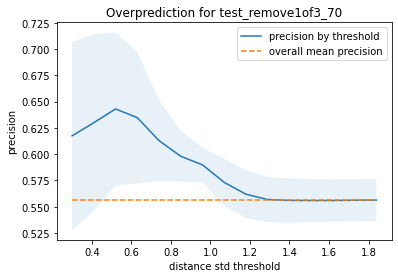

In [26]:
print("Average precision across all experiments:", pre_all_avg)
pre_bin_mean = pre_rec_f1_roc_acc_mean[0][:plot_range]
pre_bin_std = pre_rec_f1_roc_acc_std[0][:plot_range]

confidence_range = [
    MIN_STD + i*(MAX_STD-MIN_STD)/args_N_bins 
    for i in range(args_N_bins)][:plot_range]
# precision average over experiment, binned
plt.plot(confidence_range, pre_bin_mean,
         label='precision by threshold')
# average overall precision
plt.plot(confidence_range, [pre_all_avg for i in range(args_N_bins)[:plot_range]], 
         '--', label='overall mean precision')
lower = np.array(pre_bin_mean) - np.array(pre_bin_std)
upper = np.array(pre_bin_mean) + np.array(pre_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("distance std threshold")
plt.ylabel("precision")
plt.legend(loc='upper right')
plt.title("Overprediction for " + args_test_data)

Average recall across all experiments: 0.44535519125683065


Text(0.5, 1.0, 'Overprediction for test_remove1of3_70')

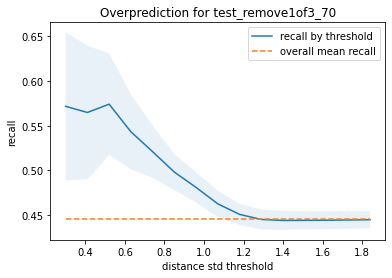

In [27]:
print("Average recall across all experiments:", rec_all_avg)
rec_bin_mean = pre_rec_f1_roc_acc_mean[1][:plot_range]
rec_bin_std = pre_rec_f1_roc_acc_std[1][:plot_range]
 
confidence_range = [
    MIN_STD + i*(MAX_STD-MIN_STD)/args_N_bins 
    for i in range(args_N_bins)][:plot_range]
# recall average over experiment, binned
plt.plot(confidence_range, rec_bin_mean,
         label='recall by threshold')
# average overall recall
plt.plot(confidence_range, [rec_all_avg for i in range(args_N_bins)][:plot_range], 
         '--', label='overall mean recall')
lower = np.array(rec_bin_mean) - np.array(rec_bin_std)
upper = np.array(rec_bin_mean) + np.array(rec_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("distance std threshold")
plt.ylabel("recall")
plt.legend(loc='upper right')
plt.title("Overprediction for " + args_test_data)

Average F1 across all experiments: 0.4702619754875245


Text(0.5, 1.0, 'Overprediction for test_remove1of3_70')

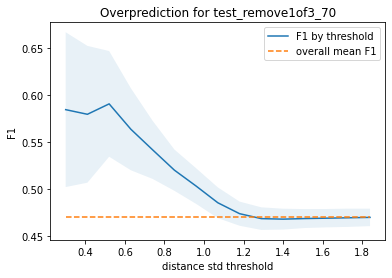

In [28]:
print("Average F1 across all experiments:", f1_all_avg)
f1_bin_mean = pre_rec_f1_roc_acc_mean[2][:plot_range]
f1_bin_std = pre_rec_f1_roc_acc_std[2][:plot_range]
 
confidence_range = [
    MIN_STD + i*(MAX_STD-MIN_STD)/args_N_bins 
    for i in range(args_N_bins)][:plot_range]
# F1 average over experiment, binned
plt.plot(confidence_range, f1_bin_mean,
         label='F1 by threshold')
# average overall F1
plt.plot(confidence_range, [f1_all_avg for i in range(args_N_bins)][:plot_range], 
         '--', label='overall mean F1')
lower = np.array(f1_bin_mean) - np.array(f1_bin_std)
upper = np.array(f1_bin_mean) + np.array(f1_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("distance std threshold")
plt.ylabel("F1")
plt.legend(loc='upper right')
plt.title("Overprediction for " + args_test_data)

Average AUC across all experiments: 0.7219986925985279


Text(0.5, 1.0, 'Overprediction for test_remove1of3_70')

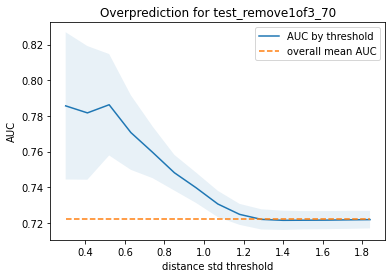

In [29]:
print("Average AUC across all experiments:", roc_all_avg)
auc_bin_mean = pre_rec_f1_roc_acc_mean[3][:plot_range]
auc_bin_std = pre_rec_f1_roc_acc_std[3][:plot_range]
 
confidence_range = [
    MIN_STD + i*(MAX_STD-MIN_STD)/args_N_bins 
    for i in range(args_N_bins)][:plot_range]
# AUC average over experiment, binned
plt.plot(confidence_range, auc_bin_mean,
         label='AUC by threshold')
# average overall AUC
plt.plot(confidence_range, [roc_all_avg for i in range(args_N_bins)][:plot_range], 
         '--', label='overall mean AUC')
lower = np.array(auc_bin_mean) - np.array(auc_bin_std)
upper = np.array(auc_bin_mean) + np.array(auc_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("distance std threshold")
plt.ylabel("AUC")
plt.legend(loc='upper right')
plt.title("Overprediction for " + args_test_data)

## Accuracy

Average accuracy across all experiments: 0.44002732240437165


Text(0.5, 1.0, 'Overprediction for test_remove1of3_70')

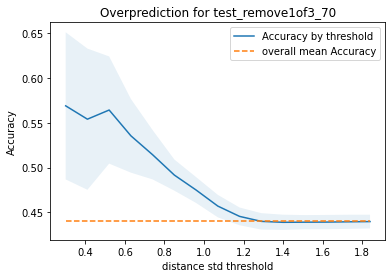

In [30]:
print("Average accuracy across all experiments:", acc_all_avg)
acc_bin_mean = pre_rec_f1_roc_acc_mean[4][:plot_range]
acc_bin_std = pre_rec_f1_roc_acc_std[4][:plot_range]
 
confidence_range = [
    MIN_STD + i*(MAX_STD-MIN_STD)/args_N_bins 
    for i in range(args_N_bins)][:plot_range]
# accuracy average over experiment, binned
plt.plot(confidence_range, acc_bin_mean,
         label='Accuracy by threshold')
# average overall acc
plt.plot(confidence_range, [acc_all_avg for i in range(args_N_bins)][:plot_range], 
         '--', label='overall mean Accuracy')
lower = np.array(acc_bin_mean) - np.array(acc_bin_std)
upper = np.array(acc_bin_mean) + np.array(acc_bin_std)
plt.fill_between(confidence_range, lower, upper, alpha=.1)
plt.xlabel("distance std threshold")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.title("Overprediction for " + args_test_data)